<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_8_3_RNN_engine_lifetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8.1 Engine lifetime with RNNs

In this exercise, you will develop a Recurrent Neural Network capable of estimating the lifetime of engines. Your final submission should include a link to your google collab notebook, and a pdf adressing the questions asked in the task. You can use this template to get started: https://colab.research.google.com/drive/1HeCd0EIGTEbAAVNgyWeMKMgCejKcA031#scrollTo=A_dA-aOjvbza

The paper that can help you with the exercises can be found here:\
Wang, Y., Zhao, Y. & Addepalli, S. Practical Options for Adopting Recurrent Neural Network and Its Variants on Remaining Useful Life Prediction. Chin. J. Mech. Eng. 34, 69 (2021). https://doi.org/10.1186/s10033-021-00588-x

##Experimental Scenario

The data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. Therefore, the labels for the training data set have to be determined from the remaining time steps. In the test set, the time series ends some time prior to system failure. The objective of the exercise is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided is a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1\.	unit number\
2\.	time, in cycles\
3\.	operational setting 1\
4\.	operational setting 2\
5\.	operational setting 3\
6\.	sensor measurement  1\
7\.	sensor measurement  2\
... \
26\.	sensor measurement  21

For this exercise we only consider the FD001 data set.

Data Set: FD001\
Train trjectories: 100\
Test trajectories: 100\
Conditions: ONE (Sea Level)\
Fault Modes: ONE (HPC Degradation)




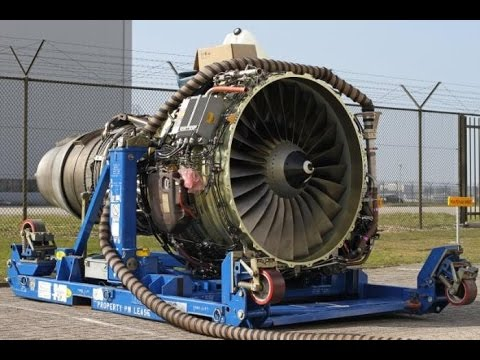



Y. Dwivedi, Predicting Engine Failure using C-MAPSS data, 2018 (https://yajasd.github.io/2018/06/04/Predicting-Engine-Failure/)

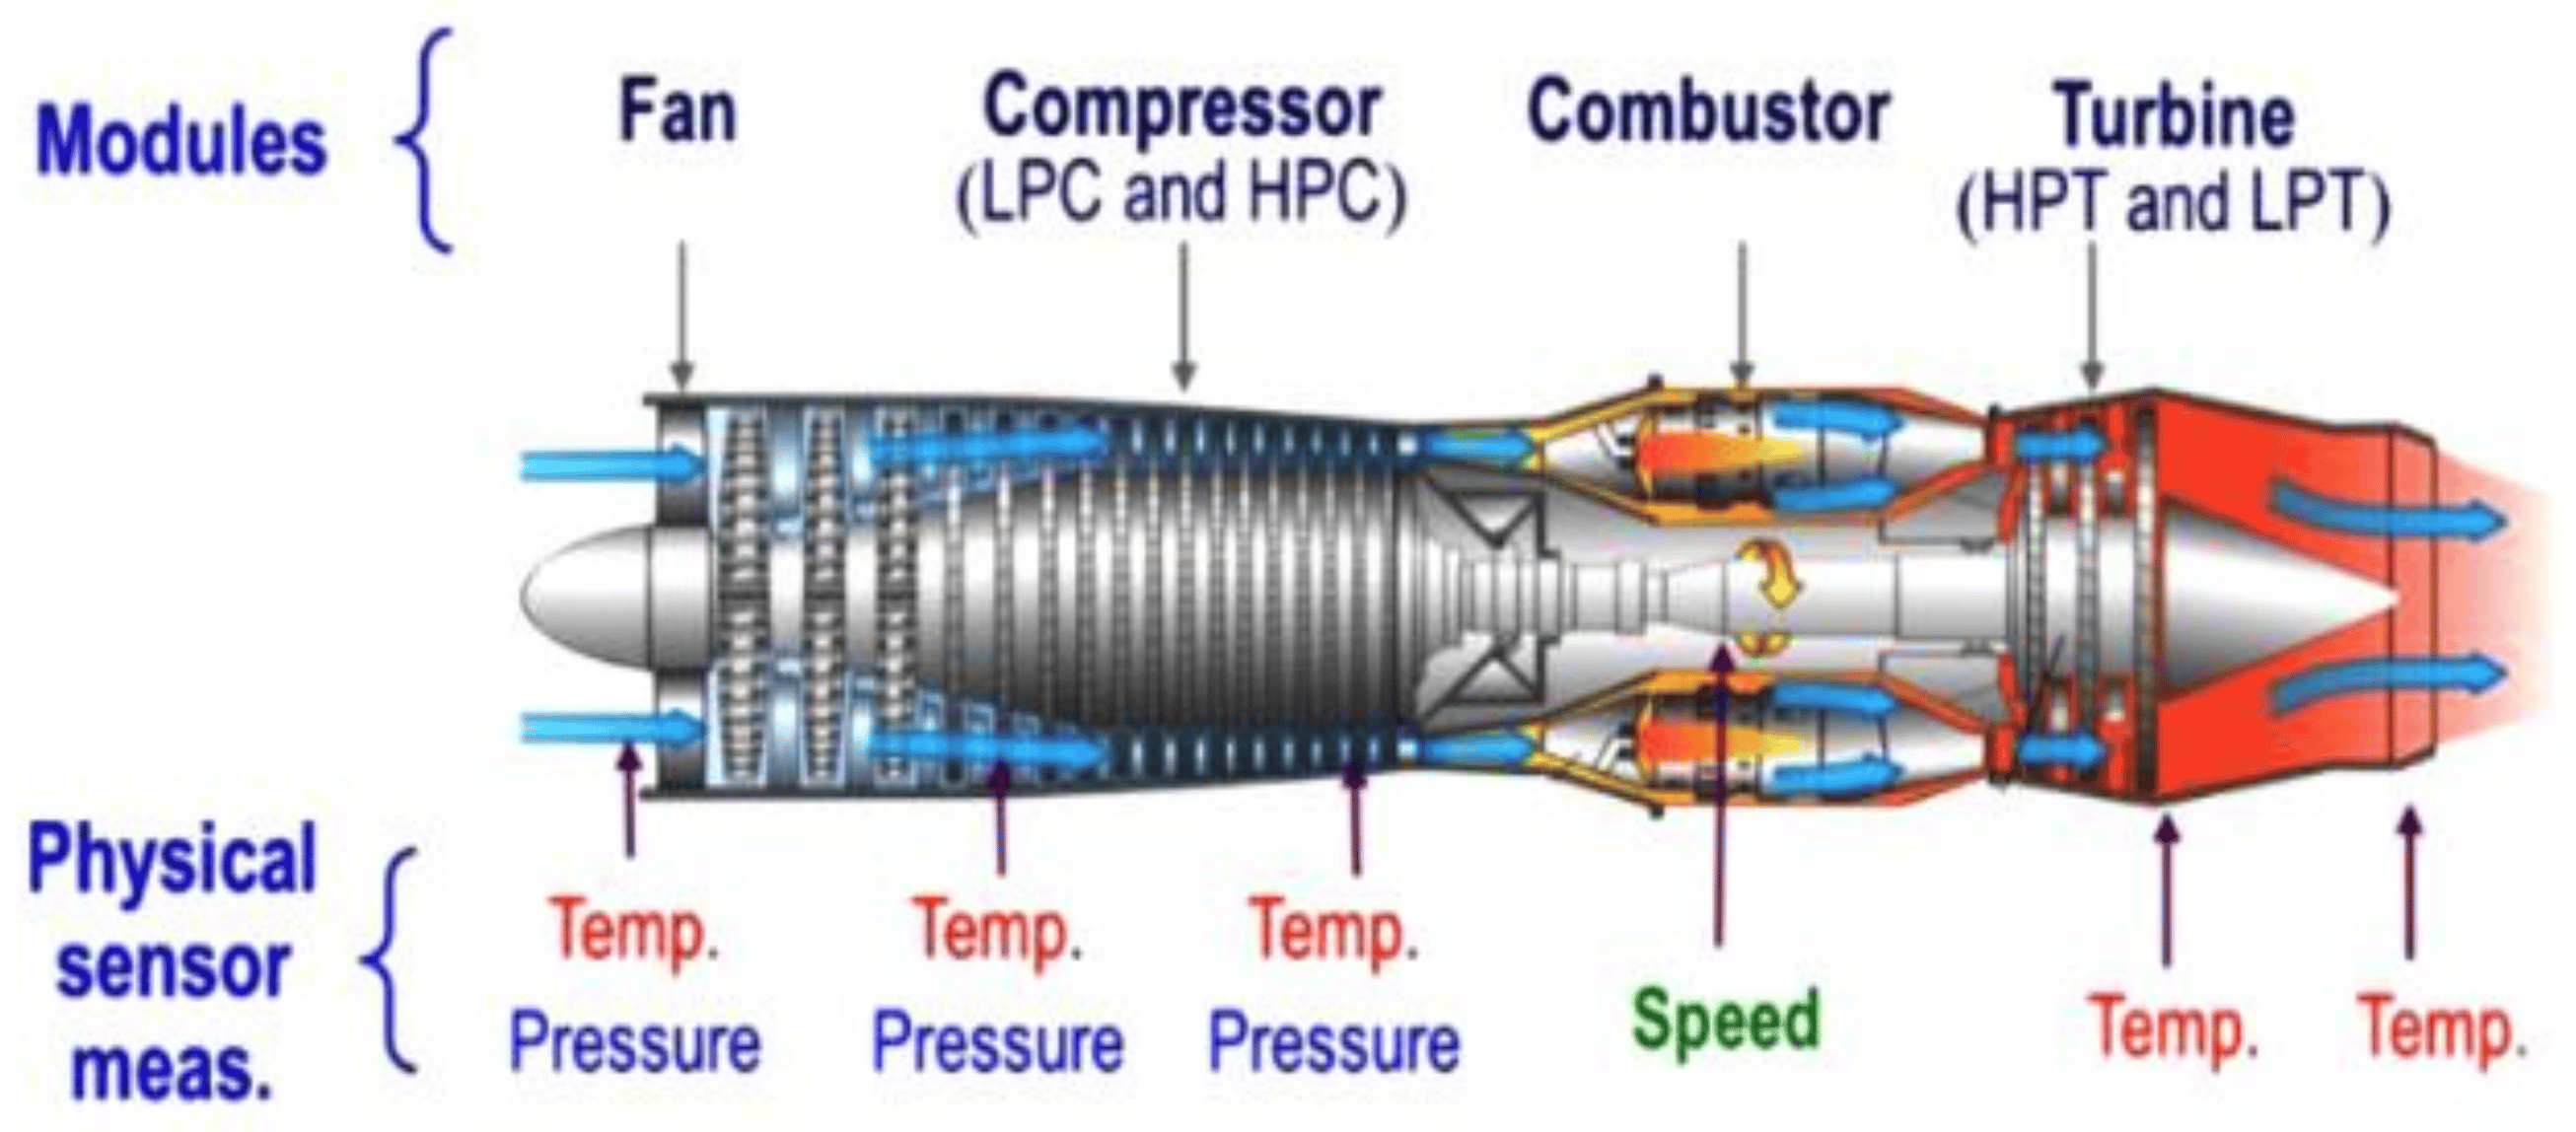


Muneer, A.; Taib, S.M.; Naseer, S.; Ali, R.F.; Aziz, I.A. Data-Driven Deep Learning-Based Attention Mechanism for Remaining Useful Life Prediction: Case Study Application to Turbofan Engine Analysis. Electronics 2021, 10, 2453. https://doi.org/10.3390/electronics10202453

## Exercises

The data structure of the input data is the most important thing when training a RNN. Make sure you understand the format of the input data.


1.   Normalize the input data. It can be useful to use helper functions instead of manually implementing the normaliztion. Here, you get to know the `sklearn` package. Please use the functions `sklearn.preprocessing.StandardScaler().fit()` and `sklearn.preprocessing.StandardScaler().transform()`. For additional help see the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and this tutorial (https://www.youtube.com/watch?v=ZddUwo4R5ug).

2.   Make several plots to understand the input data for all, and for a single unit. How do the plots change after the normalization? Also plot the labels for the training data.

3.   Explain in your notes what the for-loop in section 10 is doing and why it is important. Is there an optimal value for n_past? Try to find it. Hint: Consider the input dimensions for the test data set.

4.   Set up your RNN in section 13 using `keras.layers.LSTM()`. Think about what dimension the final dense layer should have.

5.   Set up the `model.fit` function in section 14 and train your RNN model. Test different callback options. What do you notice during training? Write down your reflections and what thoughts went into your final training strategy.

6.   Plot the training and validation loss against training epochs.

7.   Apply the trained model to both, the trainning data set, and the test data set.

8.   Make several plots to evaluate the trained model. Start with a plot where you compare the training data labels to the predictions your final model makes for the training data set. For the test data, plot the predictions and the true values for each unit. In a second figure, plot the residuals of your predictions as a histogram.

9.   Use the MSE function to break down the performance of your model to a single number.

10.   If you want to be 95% sure that the engine still has at least 20 cycles to go, at what network output should you recommend maintenance? (The histogram with the residuals can help you with your estimate.)



## 1) Importing relevant libraries

In [ ]:
# you don't have to touch this
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

layers = keras.layers
models = keras.models

print(keras.__version__)

3.5.0


## 2) Downloading the Data

In [ ]:
#downloading the data set
# you don't have to touch this
if os.path.exists("application%2Fzip") == False:
  !wget https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
  !unzip application%2Fzip

--2024-11-18 10:56:34--  https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
Resolving data.nasa.gov (data.nasa.gov)... 128.102.186.77, 2001:4d0:6311:2c05:60b0:5ad8:1210:ea07
Connecting to data.nasa.gov (data.nasa.gov)|128.102.186.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip [following]
--2024-11-18 10:56:34--  https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip
Reusing existing connection to data.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip’

application%2Fzip       [    <=>             ]  11.85M  17.7MB/s    in 0.7s    

2024-11-18 10:56:35 (17.7 MB/s) - ‘application%2Fzip’ saved [12425978]

Archive:  application%2Fzip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.t

## 3) Preparing the training data

In [ ]:
#training data set without labels
# you don't have to touch this

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)


##4) Plot the data for all units

In [ ]:
#plot the input data for all units
#...


##5) Plot the data for a single unit

In [ ]:
#plot the input data for all units
#...



##6) Drop irrelevant columns and normalize the training data

In [ ]:
#training data set without labels

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

#choose which columns of data you want to keep and which you want to drop.
#Training with everything works but might not be the best choice.
#data_train = data_train.drop(['xxx'], axis=1)
#...

#normalization of the training data
#...
data_train_scaled = data_train
#columns = data_train_scaled.shape[1]

##7) Plot the normalized the training data for all units and a single unit

In [ ]:
#plot the normalized input data for all units and a single unit
#...

## 8) Preparing the labels for the training data

In [ ]:
#calculate the RUL per time step (labels for training)
# you don't have to touch this

data_numpy = np.genfromtxt('train_FD001.txt')

engine_time = []

for i in range(len(data_numpy)):
  if data_numpy[i, 0] != data_numpy[i-1, 0]:
      time_steps_data = []
      engine_time.append(time_steps_data)
  time_steps_data.append(data_numpy[i, 1])

engine_RUL = []

for i in range(len(engine_time)):
  rul_new_data = np.array(engine_time[i])
  engine_RUL += list(np.flip(rul_new_data))

label_train = pd.DataFrame(engine_RUL)
label_train.columns = ['RUL']

print(label_train.shape)

(20631, 1)


##9) Plot cycle time and RUL for all units

In [ ]:
#plot the labels of the training data set
#...

## 10) Creating time series samples

In [ ]:
#creating time series samples with length n_past to predict the RUL n_future steps in the future

trainX = []
trainY = []

n_future = 1
n_past =30

for i in range(n_past, len(data_train_scaled) - n_future +1):
    trainX.append(data_train_scaled[i - n_past:i, 0:data_train_scaled.shape[1]])
    trainY.append(label_train[i + n_future - 1:i + n_future])

trainX_all, trainY_all = np.array(trainX), np.array(trainY)[:,0]

print('trainX shape == {}.'.format(trainX_all.shape))
print('trainY shape == {}.'.format(trainY_all.shape))

InvalidIndexError: (slice(0, 30, None), slice(0, 26, None))

## 11) Preparing the test data

In [ ]:
#test data set without labels

data_test = pd.read_csv('test_FD001.txt', delimiter=' ', header=None)

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))
name_list.append('empty1')
name_list.append('empty2')
data_test.columns = name_list

data_test = data_test.drop(['empty1'], axis=1)
data_test = data_test.drop(['empty2'], axis=1)

#drop the unneccesary columns
#data_test = data_test.drop(['xxx'], axis=1)
#...

#normalization of the test data
#...
#data_test_scaled=


data_test_list = []
time_steps_data = np.empty((2, columns))

for i in range(len(data_test_scaled)):

  if i == len(data_test_scaled)-1:
    data_test_list.append(time_steps_data)

  elif data_test_scaled[i, 0] != data_test_scaled[i-1, 0]:
    time_steps_data = time_steps_data[1:]
    data_test_list.append(time_steps_data)
    time_steps_data = np.empty(columns)

  time_steps_data = np.vstack((time_steps_data, data_test_scaled[i]))
data_test_list = data_test_list[1:]

print('data_test_list length == {}.'.format(len(data_test_list)))
print('data_test_list first element shape == {}.'.format(data_test_list[0].shape))

## 12) Preparing the labels for the test data

In [ ]:
#test labels at the end of the series of each unit
# you don't have to touch this

label_test = pd.read_csv('RUL_FD001.txt', delimiter=' ', header=None)

name_list = ['RUL_final', 'empty']
label_test.columns = name_list
label_test = label_test.drop(['empty'], axis=1)

label_test_array = np.array(label_test)[:,0]

print('label_test shape == {}.'.format(label_test.shape))
print('label_test_array shape == {}.'.format(label_test_array.shape))

## 13) Define the RNN

In [ ]:
#Define the LSTM architecture

last_layer =

model = models.Sequential()
#...

model.add(layers.Dense(last_layer))

model.compile(optimizer=, loss=)
model.summary()

## 14) Train the RNN

In [ ]:
#Define callbacks to save the best model during the training

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
#keras.callbacks.ReduceLROnPlateau(factor=, patience=, verbose=, min_lr=),
#keras.callbacks.EarlyStopping(patience=, verbose=)
#keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor=, mode=)


results = model.fit(, ,
    epochs=,
    batch_size=,
    verbose=,
    validation_split=,
    callbacks=[])

## 15) Plot the results and Evaluate the performance

In [ ]:
#Plotting training loss and validation loss

In [ ]:
#Testing on the training set to predict the RUL

In [ ]:
#Plotting the true RUL and the network prediction for the training data set

In [ ]:
#Testing on the n_past last samples of the test set to predict the RUL

#you can load the best model of your callback option via
#model.load_weights("best_model.keras")

In [ ]:
#Plotting the prediction and the true values for each unit
#Hint: It's easier to compare the true values and the predicted values if you order them in a smart way.

In [ ]:
#calculate the MSE of the two arrays

##16) Recommend Maintenance

In [ ]:
#Plotting the residuals in a histogram and determine the standard diviation

In [ ]:
#answer to question 10:

output_for_maint =
print('The engine should be recomended for maintainance with an output below: ', )